# Convert volumetric mesh (unstructed grid) to volume node

## Get sample input data and output volume

In [1]:
# Load sample unstructured grid
sampleModelFile = slicer.app.temporaryPath+'/PentaHexa.vtk'
slicer.util.downloadFile('https://raw.githubusercontent.com/Slicer/Slicer/master/Libs/MRML/Core/Testing/TestData/PentaHexa.vtk', sampleModelFile)
[success, modelNode] = slicer.util.loadModel(sampleModelFile, returnNode=True)

Requested file has been found: C:/Users/andra/AppData/Local/Temp/Slicer/PentaHexa.vtk


In [2]:
# Set output volume properties
volumeNodeName = "MyNewVolume"
imageSize = [100, 100, 100]
voxelType = vtk.VTK_FLOAT

In [3]:
# Create an empty output volume
bounds=[0,0,0,0,0,0]
modelNode.GetBounds(bounds)
imageOrigin = [bounds[0], bounds[2], bounds[4]]
imageSpacing = [(bounds[1]-bounds[0])/imageSize[0], (bounds[3]-bounds[2])/imageSize[1], (bounds[5]-bounds[4])/imageSize[2]]
imageDirections = [[1,0,0], [0,1,0], [0,0,1]]
imageData = vtk.vtkImageData()
imageData.SetDimensions(imageSize)
imageData.AllocateScalars(voxelType, 1)
# Create volume node
volumeNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode", volumeNodeName)
volumeNode.SetOrigin(imageOrigin)
volumeNode.SetSpacing(imageSpacing)
volumeNode.SetIJKToRASDirections(imageDirections)
volumeNode.SetAndObserveImageData(imageData)
volumeNode.CreateDefaultDisplayNodes()

## Fill volume with model's content

In [4]:
# Sample the mesh at each voxel of the image volume

# Set up matrices to put model points into ijk space of volume
# This assumes points are in RAS space of volume (i.e. RAS==world)
transformer = vtk.vtkTransformFilter()
transformer.SetInputConnection(modelNode.GetMeshConnection())
matrixRasToIjk = vtk.vtkMatrix4x4()
volumeNode.GetRASToIJKMatrix(matrixRasToIjk)
transformRasToIjk = vtk.vtkTransform()
transformRasToIjk.SetMatrix(matrixRasToIjk)
transformer.SetTransform(transformRasToIjk)

probe = vtk.vtkProbeFilter()
probe.SetSourceConnection(transformer.GetOutputPort())
probe.SetInputConnection(volumeNode.GetImageDataConnection())
probe.Update()
volumeNode.SetAndObserveImageData(probe.GetOutput())

## Display result

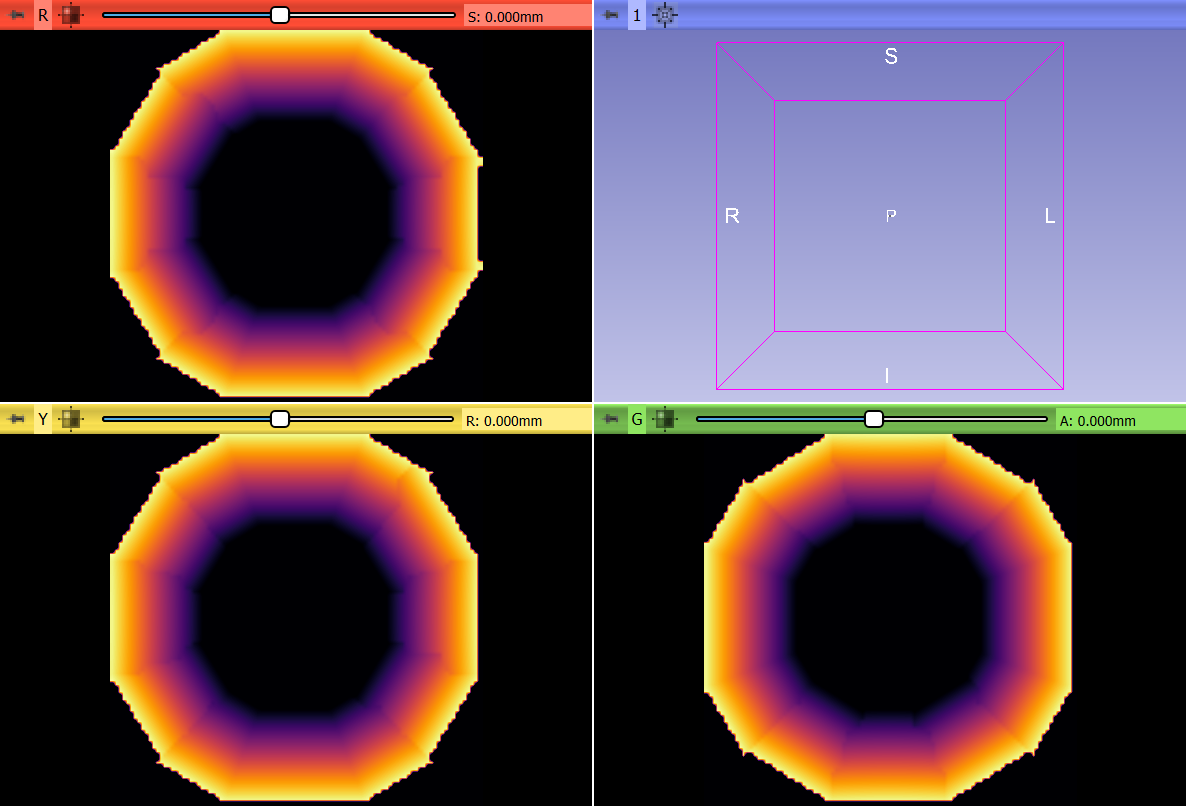

In [5]:
# Set colormap for volume display
volumeNode.GetDisplayNode().SetAndObserveColorNodeID(getNode('Inferno').GetID())
# Show all sides of the mesh
modelNode.GetDisplayNode().BackfaceCullingOff()
# Show volume in slice viewers
slicer.util.setSliceViewerLayers(background=volumeNode)
sliceLogics = slicer.app.layoutManager().mrmlSliceLogics()
for i in range(sliceLogics.GetNumberOfItems()):
    sliceLogics.GetItemAsObject(i).FitSliceToAll()

display()